In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# 查看你的电脑是否支持gpu加速,就算返回False也没关系
torch.cuda.is_available()

True

In [3]:
# 有gpu就用gpu，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [4]:
device

device(type='cuda')

In [5]:
num_classes = 10 # 输出类别数
num_epochs = 5 # 迭代轮次
batch_size = 100 # 一批数据大小
learning_rate = 0.001 # 学习率

In [6]:
# 载入MNIST手写数字数据集
# 载入训练集
train_dataset = torchvision.datasets.MNIST(root='./dataset_torch/MNIST', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

# 载入测试集
test_dataset = torchvision.datasets.MNIST(root='./dataset_torch/MNIST', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader构建输入数据加载器，这个加载器是一个python生成器，可以认为是一个流水线，每次都返回一批新数据
# 训练集数据载入流水线
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# 测试集数据载入流水线
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

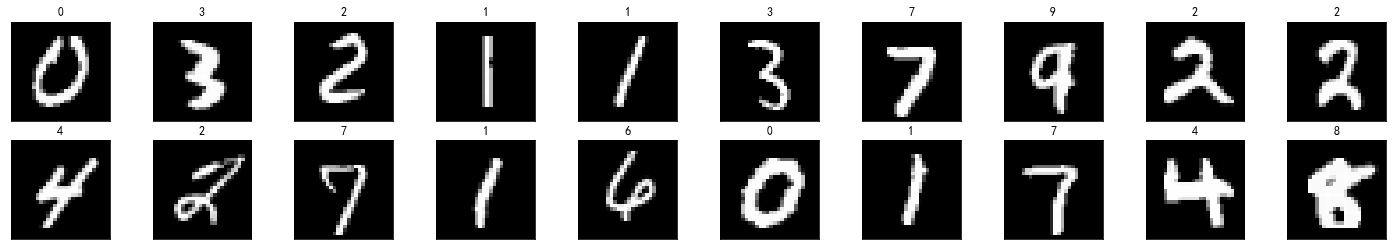

In [7]:
# 可重复运行，展示不同的图片

# 构造迭代器，获得训练集中的一批次数据
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

# 可视化图片和标签
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # .item()获取张量的数值
    ax.set_title(str(labels[idx].item()))

Text(0.5, 1.0, 'label:tensor(3)')

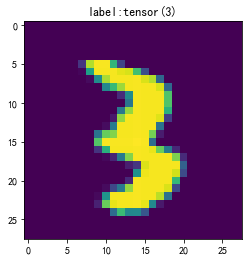

In [8]:
plt.imshow(images[1][0])
plt.title('label:'+str(labels[1]))

In [9]:
images[1].shape

(1, 28, 28)

In [10]:
np.squeeze(images[1]).shape

(28, 28)

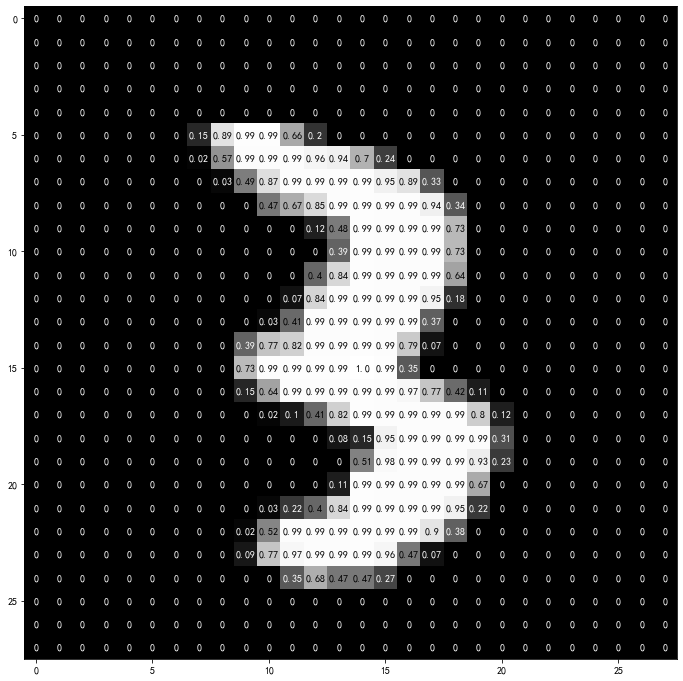

In [11]:
# 去掉图像的批次维度，只保留索引为1的单张图像的长宽像素值
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

# 遍历每一行每一列每一个像素
for x in range(width):
    for y in range(height):
        # 像素值保留两位小数，如果为0则显示0
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [12]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # 卷积+BN+Relu+最大池化
        self.layer1 = nn.Sequential(
            # 输入1个通道（灰度图），输出16个通道（16个卷积核），卷积核大小为5*5，步长为1，padding为2
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # 卷积+BN+Relu+最大池化
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# 交叉熵损失与Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
len(train_loader)

600

In [14]:
# 训练模型 最简化代码版
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.1628
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.1651
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.0359
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.0535
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.1379
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.0724
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.0411
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.0857
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.0821
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.0212
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.0857
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.0261
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.0093
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.0282
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.0456
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.0121
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.0106
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0165
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.0107
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0606
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0599
目前总轮次进程 [4/5], 当前批次进程 [400/600], 当

In [15]:
# 训练模型 存储损失函数版
total_step = len(train_loader)
loss_list = [] # 存储每一步的损失函数
loss_list2 = [] # 存储每一百步的损失函数
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            loss_list2.append(loss.item())
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.0069
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.0244
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.0135
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.0096
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.0116
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.0036
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.1362
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.0102
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.0013
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.0040
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.0073
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.0030
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.0245
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.0258
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.0058
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.0025
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.0071
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0061
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.0171
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0002
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0015
目前总轮次进程 [4/5], 当前批次进程 [400/600], 当

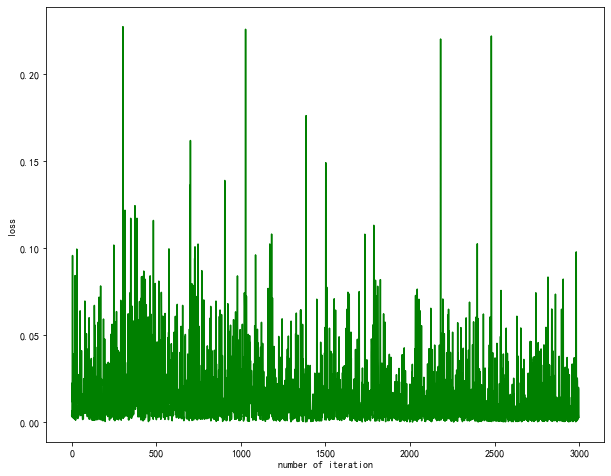

In [16]:
# 绘制训练过程中每一步的损失函数值，1步100张图片，1一个epoch需要100步，5个epoch需要3000步
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(loss_list,'g-')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.show()

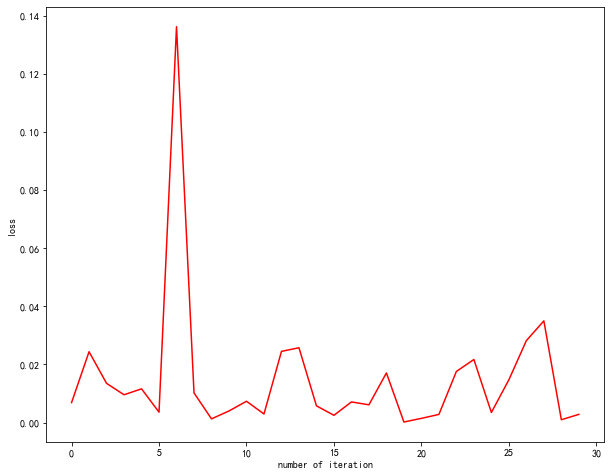

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(loss_list2,'r-')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.show()

In [18]:
model.eval()  # 评估模式，关闭BN和Dropout (BN层使用moving mean/variance而不是mini-batch上的mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('在10000张测试图片上的准确率为: {} %'.format(100 * correct / total))

# 模型存储
torch.save(model.state_dict(), './model/cnn.ckpt')

在10000张测试图片上的准确率为: 99.14 %


In [22]:
# 在测试集的一万张图片上做测试，并存储分类错误的图片、它们对应的真实标签和预测结果
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 有gpu就用gpu

import numpy as np
with torch.no_grad():
    correct = 0
    total = 0
    # 构建三个空列表，用于存放分类错误的图片，以及对应的真实标签和预测结果
    wrong_image = []
    wrong_image_label = []
    wrong_image_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        # 找出分类错误的图片，以及对应的真实标签和预测结果，分别放在三个列表里
        
        pred_result = np.argmax(outputs.cpu().detach().numpy(),axis=1)
        labels = labels.cpu().detach().numpy()
        final = (pred_result == labels)
        wrong_index = np.where(final==False)[0]
        
        for i in range(images[wrong_index].shape[0]):
            wrong_image.append(images[wrong_index][i])
            wrong_image_label.append(labels[wrong_index][i])
            wrong_image_pred.append(pred_result[wrong_index][i])
        


    print('10000张测试图片上的准确率为 {} %'.format(100 * correct / total))
    print('有{}张图片被分类错误'.format(len(wrong_image_label)))
# 模型存储
torch.save(model.state_dict(), './cnn.ckpt')

10000张测试图片上的准确率为 99 %
有86张图片被分类错误


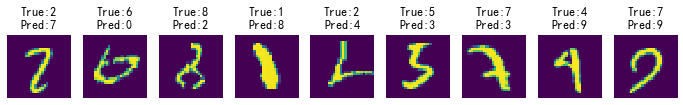

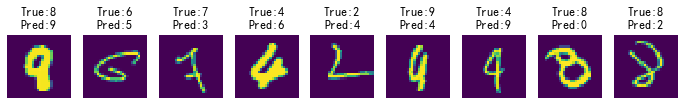

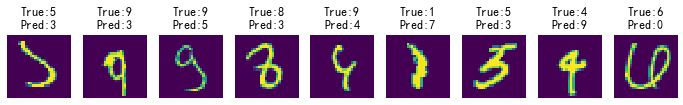

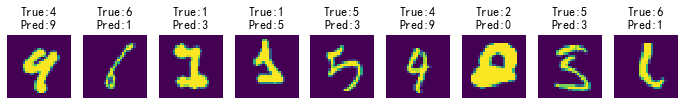

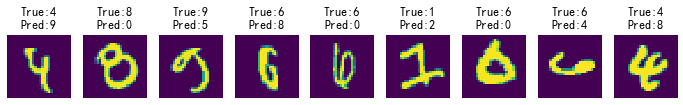

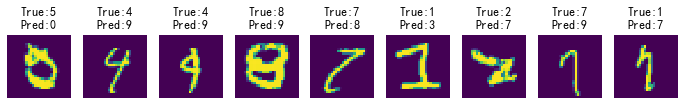

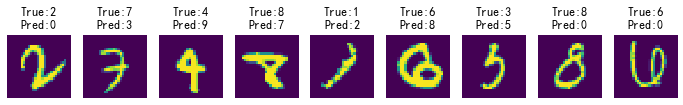

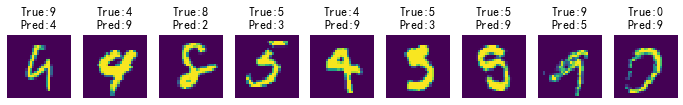

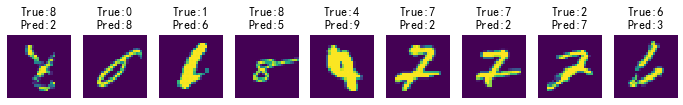

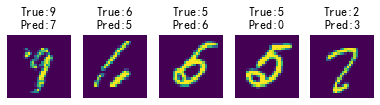

In [23]:
# 展示分类错误的图片，以及它们对应的标签和预测结果
import matplotlib.pyplot as plt 
%matplotlib inline
column = 9
for i in range(len(wrong_image_label)):
    plt.style.use({'figure.figsize':(12,12)})
    plt.subplot(1,column,i%column+1)
    plt.imshow(wrong_image[i].cpu().numpy().reshape((28,28)))
    title = 'True:{}\nPred:{}'.format(wrong_image_label[i],wrong_image_pred[i])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    if i%column == column-1:
        plt.show()

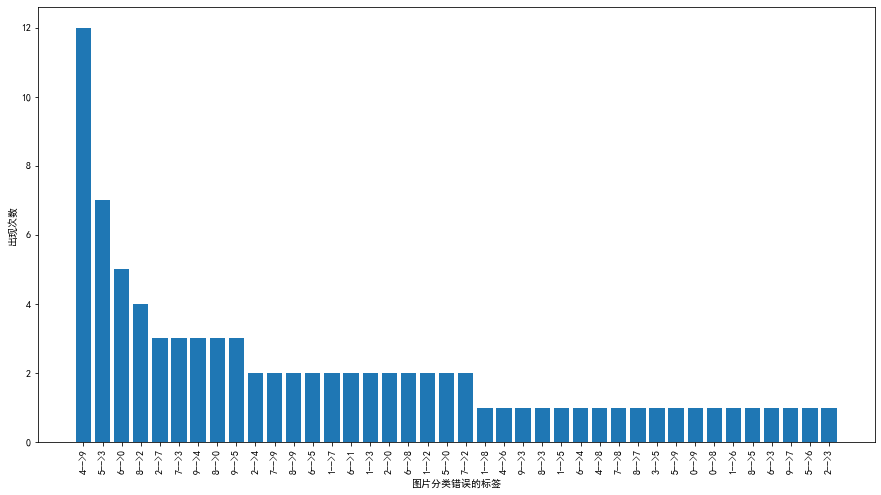

In [24]:
# 分析分类错误的图片，按出现次数降序排列画柱状图

# 构建字典存放分类错误图片的原始标签和预测标签
wrong_pair = dict()
for i in range(len(wrong_image_label)):
    word = f'{wrong_image_label[i]}-->{wrong_image_pred[i]}'
    wrong_pair[word] = wrong_pair.get(word,0) + 1

# 按照分类错误的出现次数排序
items = list(wrong_pair.items())
items.sort(key=lambda x:x[1], reverse=True) 

# 存成csv文件
import csv
with open("wrong_pair.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    #写入列名
    writer.writerow(["wrong_pair",'counts'])
    for each in items:
        new_row = [each[0],each[1]]
        #写入一行新数据
        writer.writerows([new_row])

import pandas as pd
df = pd.read_csv('wrong_pair.csv')

# 绘制柱状图
plt.style.use({'figure.figsize':(15,8)})
plt.bar(df['wrong_pair'],df['counts'])
plt.xticks(rotation=90)
plt.xlabel('图片分类错误的标签')
plt.ylabel('出现次数')
plt.show()